In [1]:
!pip install catboost
!pip install yellowbrick
!pip install ipywidgets
!pip install pandas-profiling
!jupyter nbextension enable --py widgetsnbextension

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 8.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
import os
import random
import sqlite3
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats import norm
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import catboost
import tensorflow as tf
from catboost import CatBoostRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import max_error
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, explained_variance_score

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

%matplotlib inline

<ipython-input-2-8fbb79d48ee0>:10: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


In [3]:
database = sqlite3.connect(os.path.join(os.getcwd(), "fypdbmain.sqlite"))

In [4]:
tickers = {
    "EVs": "TSLA",
    "Finance": "MS",
    "Tech": "GOOGL"
}

categories = ["EVs","Finance","Tech"]

tableName = {
    "EVs": "evDataAggr",
    "Finance": "financeDataAggr",
    "Tech": "techDataAggr"
}


In [5]:
def load_datasets(tickers, categories):
    tweet_dfs = dict()
    
    stock_dfs = dict()
    for category in categories:
      ticker = tickers[category]
      #ToDo make this line general
      tweet_df = pd.read_sql_query(f"SELECT * from {tableName[category]}",database)
      tweet_df = tweet_df.drop(columns = ['category'])
      tweet_df["date"] = tweet_df["date"].astype("datetime64")
      tweet_df["count"] = tweet_df["count"].astype("int32")
      tweet_df["neg_count"] = tweet_df["neg_count"].astype("int32")
      tweet_df["neu_count"] = tweet_df["neu_count"].astype("int32")
      tweet_df["pos_count"] = tweet_df["pos_count"].astype("int32")
      tweet_df["neg_score"] = tweet_df["neg_score"].astype("float64")
      tweet_df["neu_score"] = tweet_df["neu_score"].astype("float64")
      tweet_df["pos_score"] = tweet_df["pos_score"].astype("float64")
      tweet_df["wt_neg"] = tweet_df["wt_neg"].astype("float64")
      tweet_df["wt_neu"] = tweet_df["wt_neu"].astype("float64")
      tweet_df["wt_pos"] = tweet_df["wt_pos"].astype("float64")
      #tweet_df["mood"] = (tweet_df["wted_pos"] - tweet_df["wted_neg"]) / (tweet_df["wted_pos"] + tweet_df["wted_neu"] + tweet_df["wted_neg"])

      if(ticker!='GOOGL'):
        tweet_df["neg_count"] = -1 * tweet_df["neg_count"]
        tweet_df["neg_score"] = -1 * tweet_df["neg_score"]
        tweet_df["wt_neg"] = -1 * tweet_df["wt_neg"]
        tweet_df["neu_count"] = -1 * tweet_df["neu_count"]
        tweet_df["neu_score"] = -1 * tweet_df["neu_score"]
        tweet_df["wt_neu"] = -1 * tweet_df["wt_neu"]
        tweet_df["pos_count"] = -1 * tweet_df["pos_count"]
        tweet_df["pos_score"] = -1 * tweet_df["pos_score"]
        tweet_df["wt_pos"] = -1 * tweet_df["wt_pos"]

      tweet_dfs[ticker] = tweet_df.copy(deep=True)

      stock_df = pd.read_sql_query(f"SELECT * from stockDataAggr where category ='{category}'",database)
      stock_df = stock_df.drop(columns = ['category', 'ticker','aggrPercent'])

      stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
      stock_df["open"] = stock_df["open"].astype("float64")
      stock_df["close"] = stock_df["close"].astype("float64")
      stock_df["high"] = stock_df["high"].astype("float64")
      stock_df["low"] = stock_df["low"].astype("float64")

      stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)
      stock_dfs[ticker] = stock_df.copy(deep=True)
      del tweet_df, stock_df
            
    return tweet_dfs, stock_dfs

In [6]:
tweet_dfs, stock_dfs = load_datasets(tickers, categories)

In [7]:
tweet_dfs["MS"]

,date,neg_count,neu_count,pos_count,neg_score,neu_score,pos_score,wt_neg,wt_neu,wt_pos,count
0,2022-08-02,-766,-127,-303,-336.0,-115.406570,-196.611622,-239.981812,-152.470932,-293.251112,320
1,2022-08-01,-427,-83,-150,-194.0,-69.494362,-115.738205,-174.767426,-77.543838,-154.309587,195
2,2022-08-03,-1359,-451,-497,-411.0,-285.696716,-395.129700,-274.173561,-417.545763,-535.736023,405
3,2022-08-04,-1479,-361,-744,-374.0,-234.666542,-372.979546,-317.353912,-471.263652,-580.721989,427
4,2022-08-05,-1183,-358,-405,-420.0,-226.413116,-297.240101,-229.346766,-323.883955,-422.728630,436
...,...,...,...,...,...,...,...,...,...,...,...
238,2023-03-27,-616,-148,-284,-184.0,-148.681401,-274.666202,-192.652397,-234.922952,-482.123691,318
239,2023-03-28,-187,-54,-97,-36.0,-47.810618,-95.097759,-44.091623,-75.500702,-112.091591,47
240,2023-03-29,-498,-126,-172,-200.0,-123.980578,-195.046607,-178.972815,-142.884097,-225.294882,203
241,2023-03-30,-522,-104,-277,-141.0,-109.790652,-237.557411,-174.651938,-117.151378,-262.639870,207


In [8]:
stock_dfs["MS"]

,date,open,close,high,low
0,2022-08-01,83.660004,84.089996,84.540001,83.010002
1,2022-08-02,83.330002,83.529999,84.589996,82.959999
2,2022-08-03,84.680000,85.050003,85.589996,84.120003
3,2022-08-04,85.199997,85.360001,85.650002,84.800003
4,2022-08-05,84.989998,86.129997,86.709999,84.709999
...,...,...,...,...,...
238,2023-03-27,86.059998,84.639999,86.320000,84.360001
239,2023-03-28,84.559998,84.879997,85.169998,83.930000
240,2023-03-29,85.930000,86.239998,86.349998,85.349998
241,2023-03-30,87.260002,86.110001,87.610001,85.459999


In [9]:
def merge_datasets(categories, tickers, ticker_dfs, stock_dfs):
    merged_dfs = dict()
    
    for category in categories:
        ticker = tickers[category]
            
        temp_tweet_df = tweet_dfs[ticker].copy(deep=True)
        temp_stock_df = stock_dfs[ticker].copy(deep=True)

        temp_merged_df = pd.merge(temp_stock_df, temp_tweet_df, on=['date'])
        temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
        
        
        merged_dfs[ticker] = temp_merged_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_merged_df.shape, "\n")
        
        del temp_tweet_df, temp_stock_df, temp_merged_df
            
    return merged_dfs

In [10]:
def normalize_datasets(categories, tickers, merged_dfs, reduced=False, output_label='close'):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        
        ticker = tickers[category]
        temp_norm_df = merged_dfs[ticker].copy(deep=True)
        
        temp_norm_df = temp_norm_df.drop(columns=['date'])

        temp_norm_df = scaler.fit_transform(temp_norm_df)

        if(reduced == False):

          temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                'count','neg_score','neu_score', 'pos_score', \
                                                                'wt_neg', 'wt_neu', 'wt_pos', \
                                                                'neg_count', 'neu_count', 'pos_count'])
        else:
          columns = ['open', 'wt_neg', 'wt_neu', 'wt_pos','prev_open','prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]
          print(columns)
          temp_norm_df = pd.DataFrame(temp_norm_df, columns = columns)
        
        
        norm_dfs[ticker] = temp_norm_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
        
        del temp_norm_df
            
    return norm_dfs

In [11]:
merged_dfs = merge_datasets(categories, tickers, tweet_dfs, stock_dfs)

Data dimensions for TSLA: (243, 15) 

Data dimensions for MS: (243, 15) 

Data dimensions for GOOGL: (243, 15) 



In [12]:
def plot_corr_heatmaps(categories, tickers, norm_dfs):
    cmaps = ['YlOrBr', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu']
    for category in categories:
        ticker=tickers[category]
        plt.figure(figsize=(10,6))
        sns.heatmap(norm_dfs[ticker].corr('spearman'),cmap='RdYlGn',annot=True, linewidths=0.2)
        plt.title(f'Correlation Heatmap For {ticker}', fontsize=14)

        plt.show()

In [13]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

In [14]:
def RMSE(y_true, y_pred):
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    
    return round(RMSE, 6)

In [15]:
def print_metrics(model, X_train, X_test, y_test):
    
    n_points = X_train.shape[0] #number of datapoints
    n_features = X_train.shape[1] #number of features

    #predict probabilities for test set
    y_hat = model.predict(X_test)

    rmse_val = RMSE(y_test.reshape(-1,1), y_hat)
    print('RMSE:\t\t\t%f' % rmse_val)
    
    mse_val = mse(y_test.reshape(-1, 1), y_hat)
    print('MSE:\t\t\t%f' % mse_val)
    
    mae_val = mae(y_test.reshape(-1, 1), y_hat)
    print('MAE:\t\t\t%f' % mae_val)

    r2 = r2_score(y_test.reshape(-1,1), y_hat)
    print('R2 Score:\t\t%f' % r2)

    adj_r2 = 1-(1-r2)*(n_points-1)/(n_points-n_features-1)
    print('Adj. R2 Score:\t\t%f' % adj_r2)
    
    exp_var_score = explained_variance_score(y_test.reshape(-1,1), y_hat)
    print('Exp. Variance Score:\t%f' % exp_var_score)

    max_err = max_error(y_test.reshape(-1,1), y_hat)
    print('Max Error:\t\t%f' % max_err)

In [16]:
def plot_prediction_graph(model, X_train, X_test, y_test, output_labels_unscaled, dates, ticker,output_label='close'):
    predicted  = model.predict(X_test)
    test_label = y_test.reshape(-1,1)
    predicted = np.array(predicted).reshape(-1,1)
    print("Predicted","\t","Value")
    for i in range(len(predicted)):
      print(predicted[i],"\t",test_label[i])
    len_t = len(X_train)

    for j in range(len_t , len_t + len(X_test)):
        temp = output_labels_unscaled[j]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp

    plt.figure(figsize=(15, 10))
    plt.plot(dates, predicted, color = 'green', label = 'Predicted ' + output_label, linewidth=2)
    plt.plot(dates, test_label, color = 'red', label = 'Actual ' + output_label, linewidth=2)
    plt.title('Stock - '+output_label+' Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
    plt.legend(loc='best')
    
    # if ticker in ['TSLA', 'XOM', 'MSFT', 'MRNA']:
    #     plt.savefig(f'images/catboost-prediction-graph-{ticker}', transparent=True, dpi=400)
    
    plt.show()

In [17]:
def print_feature_importance(model, df_cols, ticker):
    sorted_feature_importance = model.feature_importances_.argsort()

    plt.figure(figsize=(10, 5))
    plt.barh(df_cols[sorted_feature_importance], 
             model.feature_importances_[sorted_feature_importance], 
             color = 'turquoise')
    plt.title(f"CatBoost Feature Importance - {ticker}")
    plt.show()

In [18]:
def get_train_test_set(ticker, norm_df, output_label = 'close'):
    temp_df = norm_df.copy(deep = True)
    output_values = temp_df.loc[:, output_label]
    temp_df.drop(columns = [output_label], inplace = True)
    
    temp_df = temp_df.to_numpy()
    output_values = output_values.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(temp_df, output_values, \
                                                        test_size = 0.2, random_state = 3, shuffle=False)
    
    Xd_train, Xd_test, yd_train, yd_test = train_test_split(merged_dfs[ticker], merged_dfs[ticker][output_label], \
                                                        test_size = 0.2, random_state = 3, shuffle=False)

    
    test_dates = Xd_test['date'] #Collect Test data dates
    
    while len(test_dates) > len(y_test): #in case the array size is higher for dates
        test_dates = test_dates[:-1].copy()
    
    
    del Xd_train, Xd_test, yd_train, yd_test #Run GC
    del temp_df, output_values #Run GC
    
    return X_train, X_test, y_train, y_test, test_dates

In [19]:
def get_unscaled_output_labels(categories, tickers, dfs, output_label='close'):
    unscaled_op_labels = dict()
    
    for category in categories:
        ticker=tickers[category]
        # print(output_label)
        unscaled_op_labels[ticker] = dfs[ticker].loc[:, output_label].copy(deep=True)

    return unscaled_op_labels

In [20]:
def train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels, output_label='close'):
#     params = {'depth': 2,
#               'iterations': 200,
#               'learning_rate': 0.03,
#               'l2_leaf_reg': 3}

    params = {
            'eval_metric': 'MAE',
            'iterations': 200,
            'l2_leaf_reg': 10,
            'depth': 4,
            'learning_rate': 0.05,
            'loss_function': 'MAE'
        }


    model = CatBoostRegressor(**params, 
                                 logging_level='Silent', 
                                 random_state=3,
                                )
    
    for category in categories:
        ticker=tickers[category]
        print(f"======CURRENTLY WORKING ON {ticker}======")
        
        X_train, X_test, y_train, y_test, dates = get_train_test_set(ticker, norm_dfs[ticker], 
                                                                      output_label)
        
        model.fit(X_train, y_train)
        
        print_feature_importance(model, norm_dfs[ticker].columns.values, ticker)
        print_metrics(model, X_train, X_test, y_test)
        plot_prediction_graph(model, X_train, X_test, y_test, unscaled_op_labels[ticker], dates, ticker,output_label)
        
        
        print(f"======FINISHED WORKING ON {ticker}======")

In [21]:
def append_prev_day_value(categories, tickers, merged_dfs, output_label='close'):
    prev_open_dfs = dict()

    column_to_drop = ['count', 'neg_score', 'neu_score', 'pos_score', 'neg_count', 'neu_count', 'pos_count']
    for i in ['low','high','close']:
      if(i != output_label):
        column_to_drop.append(i)

    
    for category in categories:
        ticker = tickers[category]
    
        t_df = merged_dfs[ticker].copy(deep = True)
        t_df = t_df.drop(columns = column_to_drop)

        t_minus1_df = t_df.copy(deep = True).drop(columns = [output_label])
        t_minus1_df = t_minus1_df.rename(columns = {'open': 'prev_open','wt_neg':'prev_wt_neg', 'wt_neu':'prev_wt_neu', 'wt_pos':'prev_wt_pos'})

        t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

        #t_df = t_df.drop(columns=['open','wt_neg', 'wt_neu', 'wt_pos'])

        prev_open_df = pd.merge(t_df, t_minus1_df, on = ['date'])

        prev_open_df = prev_open_df[['date', 'open', 'wt_neg', 'wt_neu', 'wt_pos','prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', output_label]]

        #prev_open_df = prev_open_df.rename(columns = {'open': 'prev_open','wt_neg':'prev_wt_neg', 'wt_neu':'prev_wt_neu', 'wt_pos':'prev_wt_pos'})
        
        #prev_open_df = prev_open_df.drop(columns = ['prev_open'])
        
        prev_open_dfs[ticker] = prev_open_df.copy(deep=True)
        
        del prev_open_df #Perform GC

    return prev_open_dfs

# **Predicting Close Value**

In [35]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='close')

both_open_dfs['TSLA']

,date,open,wt_neg,wt_neu,wt_pos,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,close
0,2022-08-02,294.003326,-22.682993,-25.073643,-37.357318,301.276672,-16.876412,-26.904634,-41.171774,300.586670
1,2022-08-03,305.000000,-2.331892,-6.009396,-13.196395,294.003326,-22.682993,-25.073643,-37.357318,307.396667
2,2022-08-04,311.000000,-1.167563,-2.196746,-3.635691,305.000000,-2.331892,-6.009396,-13.196395,308.633331
3,2022-08-05,302.670013,-16.216868,-16.855830,-160.879937,311.000000,-1.167563,-2.196746,-3.635691,288.170013
4,2022-08-06,298.840000,-5.747857,-10.603171,-13.781130,302.670013,-16.216868,-16.855830,-160.879937,289.300000
...,...,...,...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,-232.793960,-281.636459,-465.958222,193.720000,-14.594635,-21.290344,-30.107518,191.809998
238,2023-03-28,192.000000,-13.191043,-12.029059,-33.769606,194.419998,-232.793960,-281.636459,-465.958222,189.190002
239,2023-03-29,193.130005,-50.816797,-73.301693,-115.862161,192.000000,-13.191043,-12.029059,-33.769606,193.880005
240,2023-03-30,195.580002,-150.363192,-88.522910,-161.982104,193.130005,-50.816797,-73.301693,-115.862161,195.279999


In [36]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='close')

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'close']
Data dimensions for TSLA: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'close']
Data dimensions for MS: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'close']
Data dimensions for GOOGL: (242, 9) 



In [37]:
both_open_norm_dfs['TSLA']

,open,wt_neg,wt_neu,wt_pos,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,close
0,0.915351,0.930269,0.986030,0.981093,0.950208,0.948169,0.984976,0.979141,0.956598
1,0.968051,0.993008,0.997001,0.993455,0.915351,0.930269,0.986030,0.981093,0.990442
2,0.996805,0.996598,0.999194,0.998347,0.968051,0.993008,0.997001,0.993455,0.996587
3,0.956885,0.950203,0.990759,0.917889,0.996805,0.996598,0.999194,0.998347,0.894891
4,0.938530,0.982477,0.994357,0.993156,0.956885,0.950203,0.990759,0.917889,0.900507
...,...,...,...,...,...,...,...,...,...
237,0.438115,0.282526,0.838391,0.761786,0.434760,0.955204,0.988207,0.984802,0.416012
238,0.426518,0.959531,0.993536,0.982928,0.438115,0.282526,0.838391,0.761786,0.402992
239,0.431933,0.843536,0.958277,0.940923,0.426518,0.959531,0.993536,0.982928,0.426300
240,0.443674,0.536649,0.949518,0.917325,0.431933,0.843536,0.958277,0.940923,0.433257


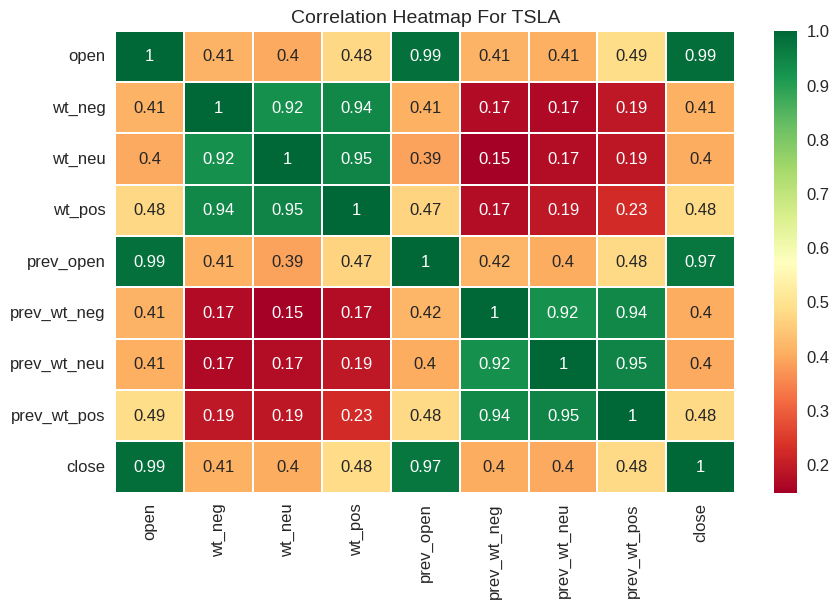

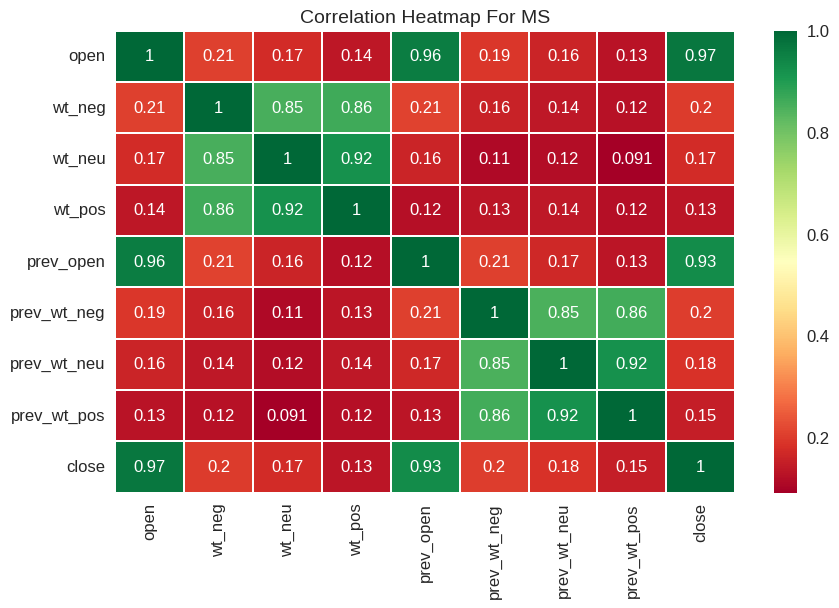

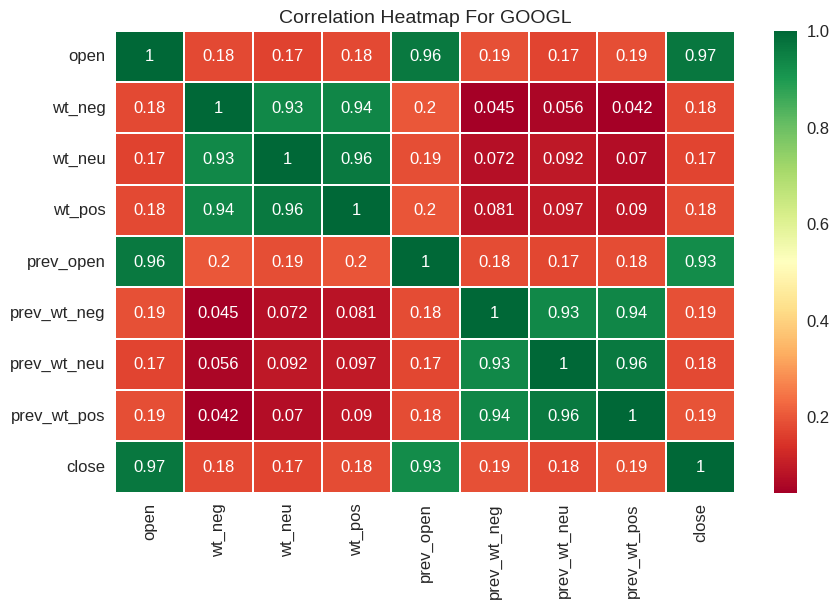

In [38]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======


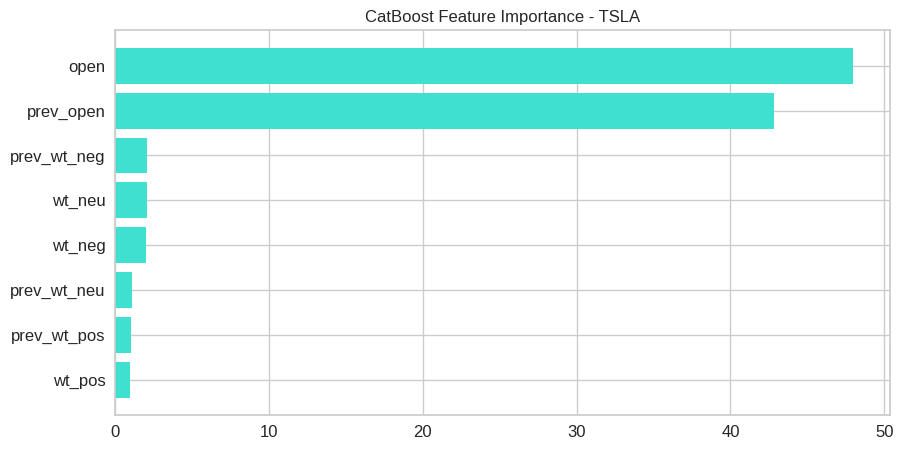

RMSE:			0.028960
MSE:			0.000839
MAE:			0.022558
R2 Score:		0.682165
Adj. R2 Score:		0.668347
Exp. Variance Score:	0.682169
Max Error:		0.078478
Predicted 	 Value
[0.45261399] 	 [0.43564257]
[0.45954984] 	 [0.43285955]
[0.44056277] 	 [0.43007652]
[0.42420525] 	 [0.50268362]
[0.47727683] 	 [0.52748237]
[0.4986924] 	 [0.46685216]
[0.47694913] 	 [0.4980121]
[0.47830923] 	 [0.47082794]
[0.4877058] 	 [0.457211]
[0.49089638] 	 [0.45040253]
[0.49286106] 	 [0.44364374]
[0.47517038] 	 [0.46098797]
[0.47986626] 	 [0.46700132]
[0.45309349] 	 [0.44120864]
[0.46816839] 	 [0.46794552]
[0.48694354] 	 [0.48131397]
[0.48320192] 	 [0.49463275]
[0.47002787] 	 [0.48509097]
[0.49781869] 	 [0.47048008]
[0.40276737] 	 [0.41148987]
[0.43052222] 	 [0.445731]
[0.41971346] 	 [0.43584136]
[0.45696109] 	 [0.43087167]
[0.46689578] 	 [0.42595168]
[0.41435933] 	 [0.39563664]
[0.39058892] 	 [0.36725971]
[0.37457004] 	 [0.32213496]
[0.33205503] 	 [0.32471922]
[0.3228705] 	 [0.32730344]
[0.29737577] 	 [0.32859556]
[0.31

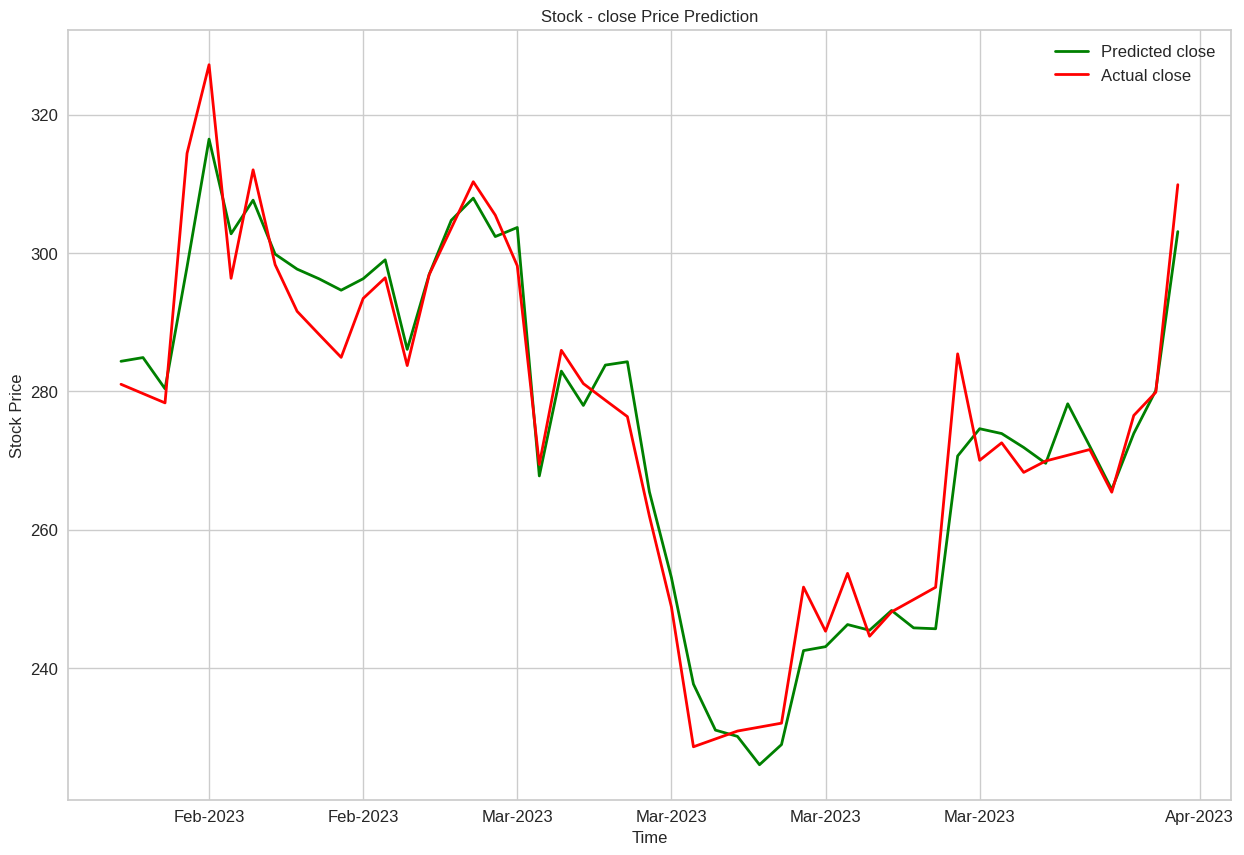

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======


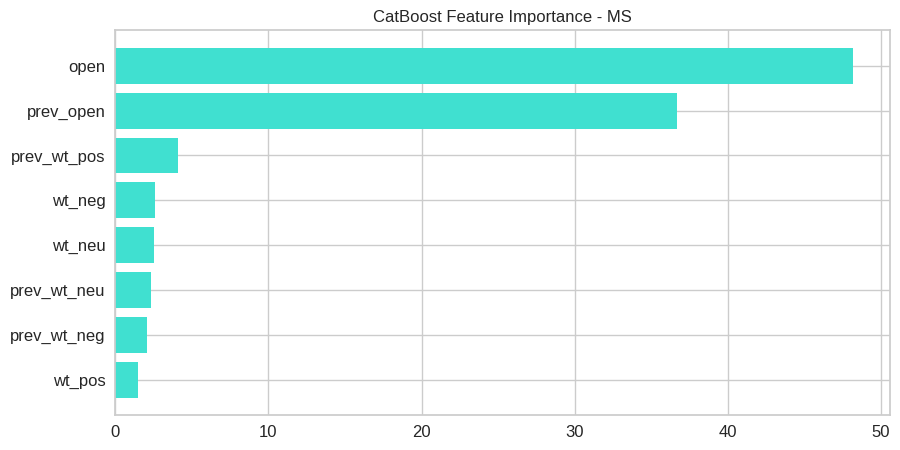

RMSE:			0.066497
MSE:			0.004422
MAE:			0.051237
R2 Score:		0.917377
Adj. R2 Score:		0.913784
Exp. Variance Score:	0.932837
Max Error:		0.198103
Predicted 	 Value
[0.916126] 	 [0.92596937]
[0.92104987] 	 [0.93576177]
[0.91894888] 	 [0.94516247]
[0.91463488] 	 [0.98942405]
[0.88997535] 	 [1.]
[0.89911904] 	 [0.95064622]
[0.90499584] 	 [0.94829612]
[0.91720898] 	 [0.91147661]
[0.91863034] 	 [0.8930669]
[0.90841804] 	 [0.88366619]
[0.91484988] 	 [0.8742656]
[0.88877426] 	 [0.86055601]
[0.89178515] 	 [0.88679984]
[0.90309132] 	 [0.87739894]
[0.90411831] 	 [0.85781425]
[0.92092873] 	 [0.84802185]
[0.90539636] 	 [0.83822933]
[0.89245469] 	 [0.83039553]
[0.82238962] 	 [0.81825303]
[0.80471135] 	 [0.81394437]
[0.89404433] 	 [0.90207599]
[0.8833031] 	 [0.9028593]
[0.91321549] 	 [0.903251]
[0.9206457] 	 [0.90403427]
[0.91570845] 	 [0.81316082]
[0.88412974] 	 [0.80689384]
[0.8600688] 	 [0.66196611]
[0.75976202] 	 [0.57775169]
[0.63601583] 	 [0.53740688]
[0.58029113] 	 [0.51703868]
[0.54310905] 	 

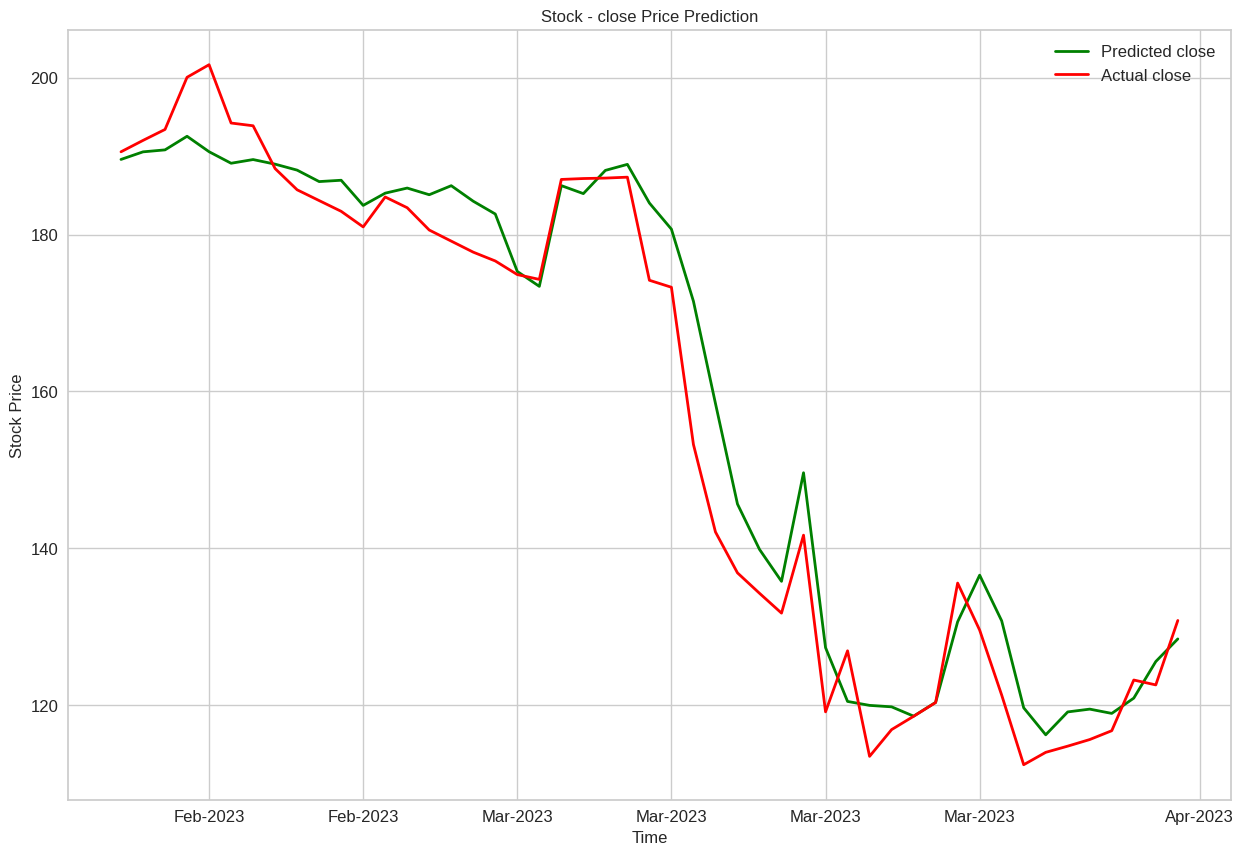

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======


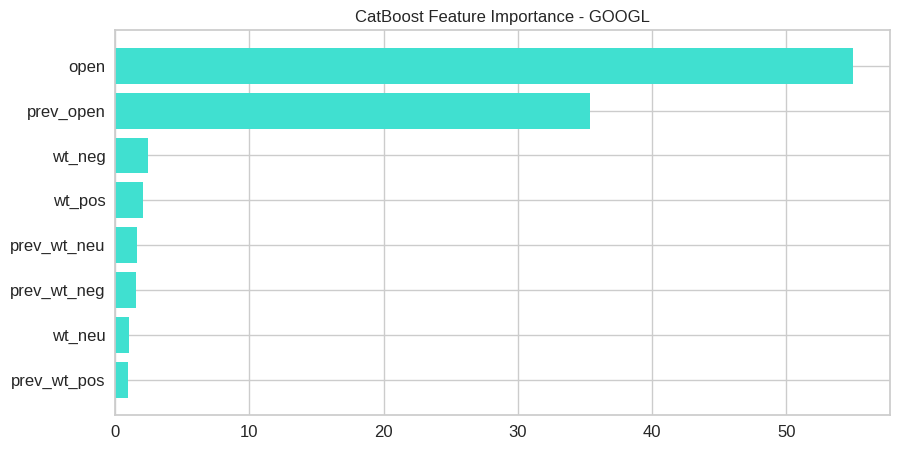

RMSE:			0.049083
MSE:			0.002409
MAE:			0.040237
R2 Score:		0.858421
Adj. R2 Score:		0.852265
Exp. Variance Score:	0.861306
Max Error:		0.135830
Predicted 	 Value
[0.32792996] 	 [0.28874513]
[0.30418844] 	 [0.28900387]
[0.32421554] 	 [0.28926262]
[0.30114481] 	 [0.29107372]
[0.29484512] 	 [0.34954725]
[0.30691451] 	 [0.31254855]
[0.30906134] 	 [0.28253551]
[0.29766572] 	 [0.24941784]
[0.26890446] 	 [0.23285898]
[0.27072536] 	 [0.22457955]
[0.24904592] 	 [0.21630014]
[0.20962886] 	 [0.21267792]
[0.19119595] 	 [0.19301419]
[0.17885934] 	 [0.14747728]
[0.14712341] 	 [0.15705044]
[0.14684389] 	 [0.16196636]
[0.14203046] 	 [0.16662361]
[0.14000612] 	 [0.1715394]
[0.14054275] 	 [0.17930144]
[0.14329908] 	 [0.22173349]
[0.20485531] 	 [0.26442436]
[0.24012032] 	 [0.28357049]
[0.26309288] 	 [0.29314358]
[0.28165571] 	 [0.30271659]
[0.31295204] 	 [0.26985771]
[0.28901547] 	 [0.27994824]
[0.29234605] 	 [0.23001292]
[0.24354378] 	 [0.18628711]
[0.18539857] 	 [0.19249676]
[0.156967] 	 [0.19560154]


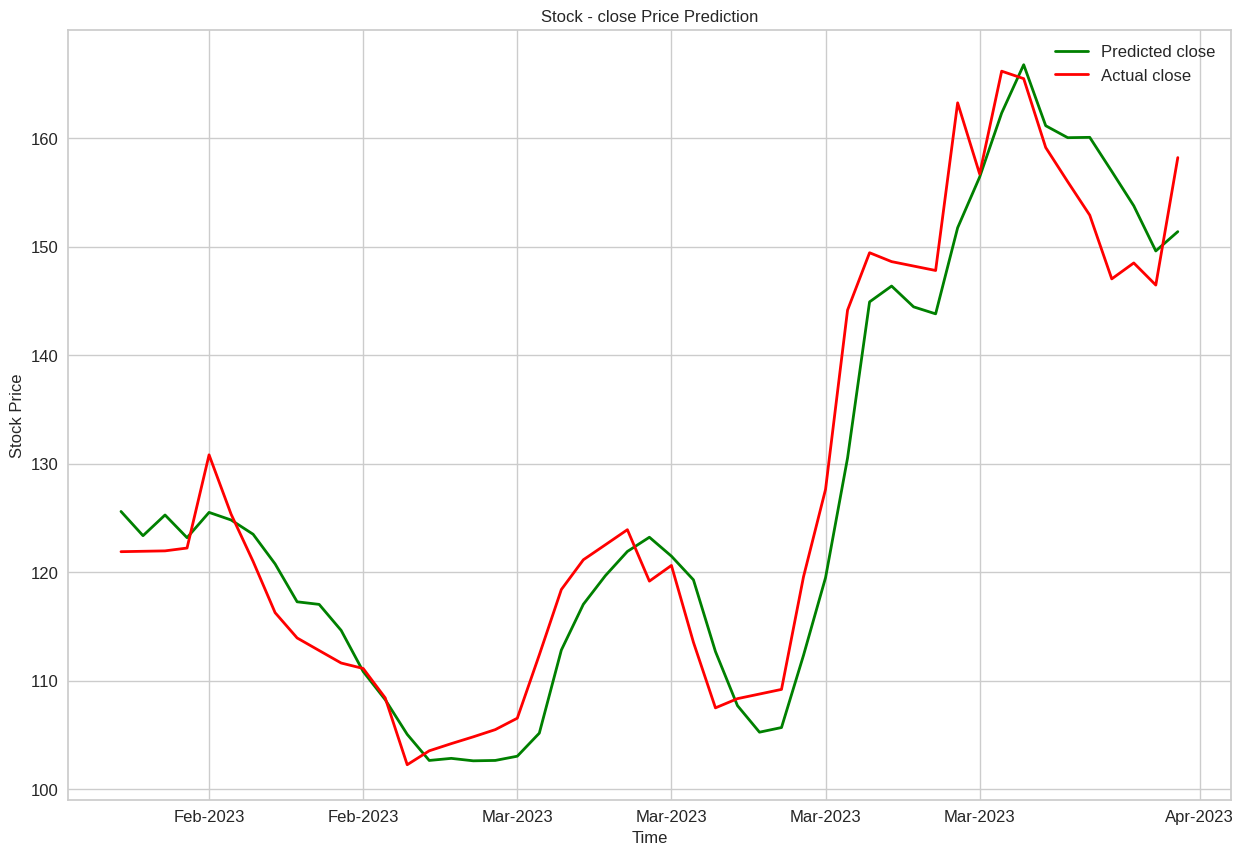

======FINISHED WORKING ON GOOGL======


In [39]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='close')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels)

# **Predicting High Value**

In [40]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='high')

both_open_dfs['TSLA']

,date,open,wt_neg,wt_neu,wt_pos,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,high
0,2022-08-02,294.003326,-22.682993,-25.073643,-37.357318,301.276672,-16.876412,-26.904634,-41.171774,307.833344
1,2022-08-03,305.000000,-2.331892,-6.009396,-13.196395,294.003326,-22.682993,-25.073643,-37.357318,309.549988
2,2022-08-04,311.000000,-1.167563,-2.196746,-3.635691,305.000000,-2.331892,-6.009396,-13.196395,313.606659
3,2022-08-05,302.670013,-16.216868,-16.855830,-160.879937,311.000000,-1.167563,-2.196746,-3.635691,304.606659
4,2022-08-06,298.840000,-5.747857,-10.603171,-13.781130,302.670013,-16.216868,-16.855830,-160.879937,304.900000
...,...,...,...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,-232.793960,-281.636459,-465.958222,193.720000,-14.594635,-21.290344,-30.107518,197.389999
238,2023-03-28,192.000000,-13.191043,-12.029059,-33.769606,194.419998,-232.793960,-281.636459,-465.958222,192.350006
239,2023-03-29,193.130005,-50.816797,-73.301693,-115.862161,192.000000,-13.191043,-12.029059,-33.769606,195.289993
240,2023-03-30,195.580002,-150.363192,-88.522910,-161.982104,193.130005,-50.816797,-73.301693,-115.862161,197.330002


In [41]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='high')

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'high']
Data dimensions for TSLA: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'high']
Data dimensions for MS: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'high']
Data dimensions for GOOGL: (242, 9) 



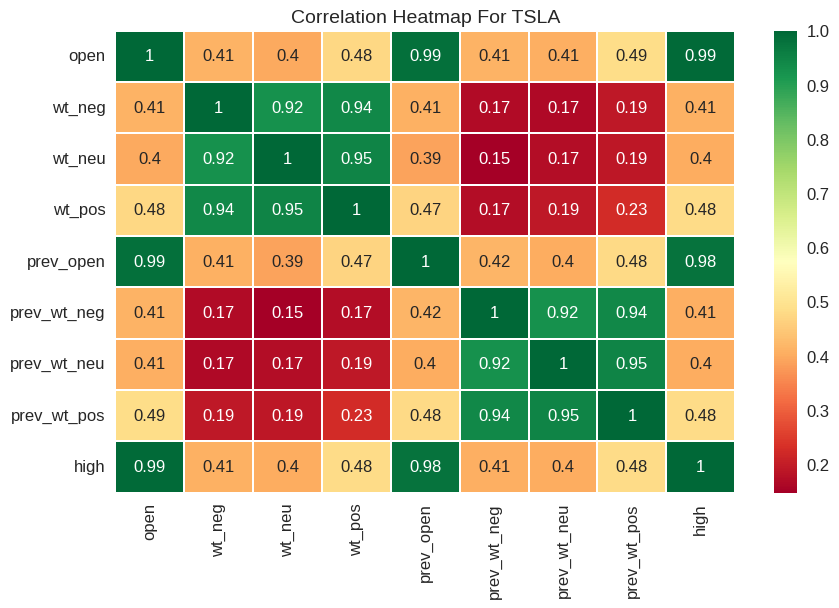

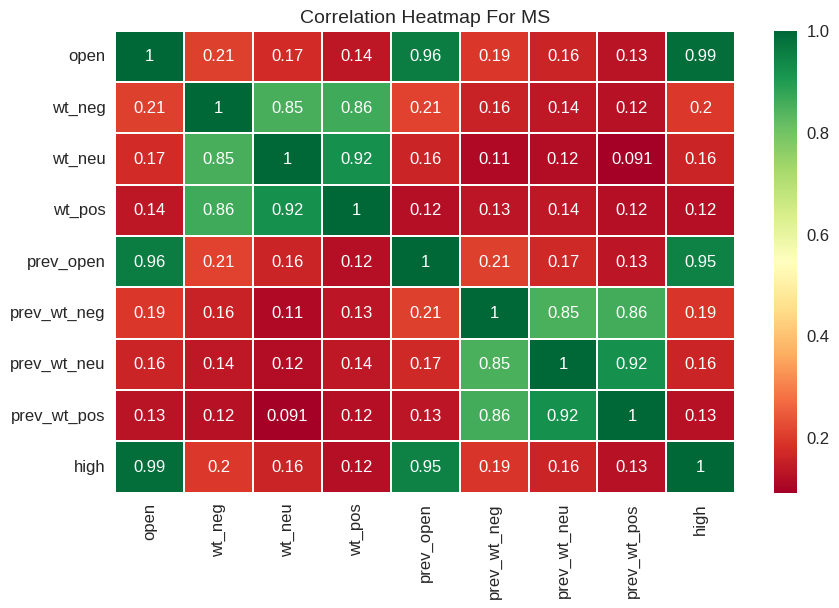

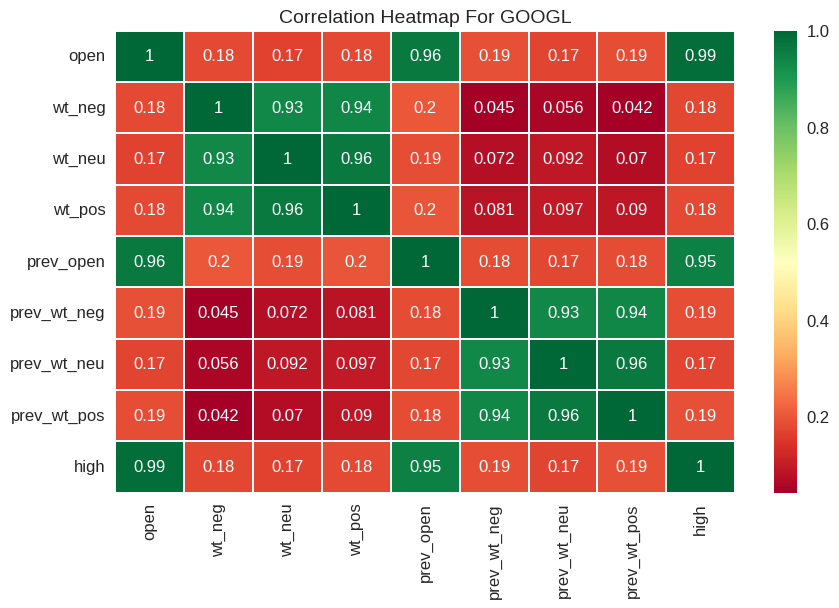

In [42]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======


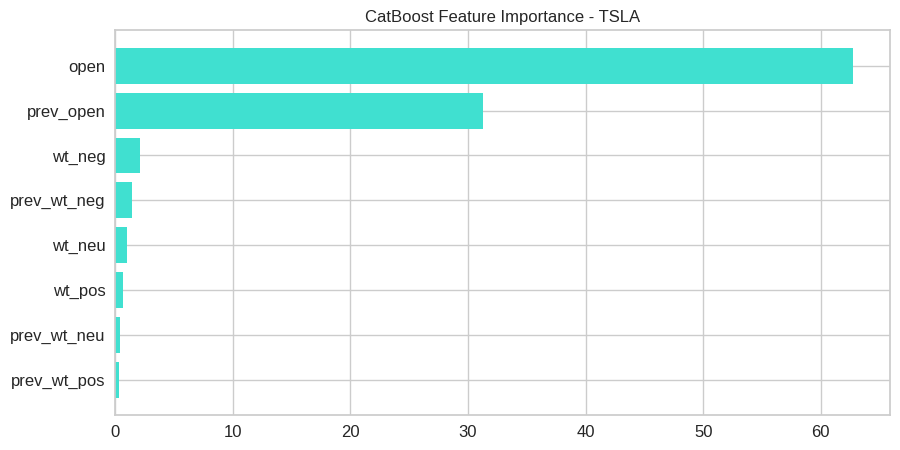

RMSE:			0.020066
MSE:			0.000403
MAE:			0.014066
R2 Score:		0.846356
Adj. R2 Score:		0.839676
Exp. Variance Score:	0.846547
Max Error:		0.074212
Predicted 	 Value
[0.46225438] 	 [0.44106778]
[0.42035047] 	 [0.4288953]
[0.431232] 	 [0.41667355]
[0.40909016] 	 [0.48330191]
[0.49143156] 	 [0.50715405]
[0.51056726] 	 [0.52188911]
[0.48743925] 	 [0.47650106]
[0.46156808] 	 [0.47965506]
[0.47431448] 	 [0.48123206]
[0.49011466] 	 [0.48202056]
[0.49124791] 	 [0.48275981]
[0.48109481] 	 [0.44471463]
[0.46766506] 	 [0.46023821]
[0.45639069] 	 [0.42342506]
[0.45034966] 	 [0.45235321]
[0.46882285] 	 [0.46684191]
[0.4774175] 	 [0.48133061]
[0.49419182] 	 [0.49025052]
[0.49877529] 	 [0.47039015]
[0.41555301] 	 [0.4041068]
[0.4308819] 	 [0.4372731]
[0.43106051] 	 [0.43264068]
[0.43756832] 	 [0.43032446]
[0.45507593] 	 [0.42800827]
[0.40633029] 	 [0.40632444]
[0.37715473] 	 [0.36837784]
[0.3638256] 	 [0.36187267]
[0.35409084] 	 [0.32791785]
[0.33217918] 	 [0.32560166]
[0.32277348] 	 [0.32446819]
[0.32

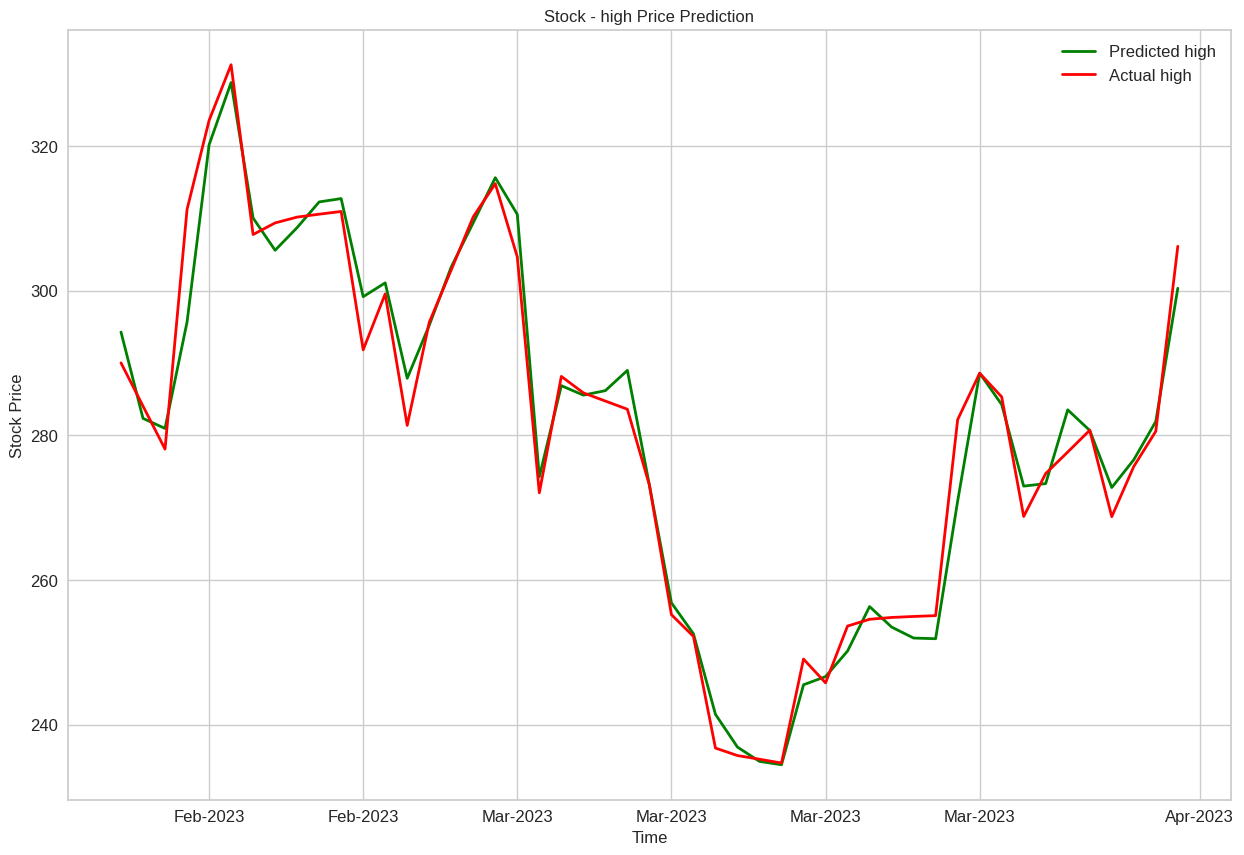

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======


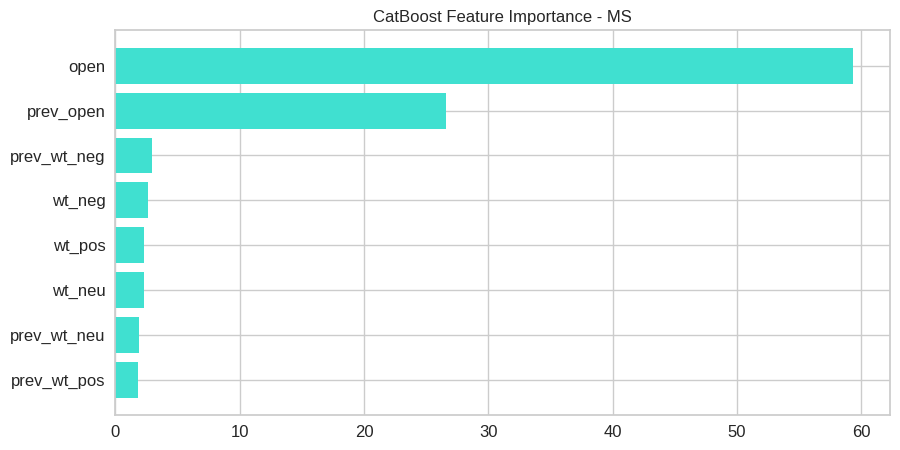

RMSE:			0.039560
MSE:			0.001565
MAE:			0.030259
R2 Score:		0.973273
Adj. R2 Score:		0.972110
Exp. Variance Score:	0.973684
Max Error:		0.105633
Predicted 	 Value
[0.93521889] 	 [0.92194919]
[0.93177336] 	 [0.93445458]
[0.91552987] 	 [0.94696006]
[0.93599658] 	 [1.]
[0.93518861] 	 [0.99870638]
[0.92892102] 	 [0.96765847]
[0.900784] 	 [0.95817157]
[0.93536168] 	 [0.93617946]
[0.90495322] 	 [0.92496773]
[0.9215802] 	 [0.91936186]
[0.89323882] 	 [0.91418722]
[0.91536909] 	 [0.87408372]
[0.90276051] 	 [0.88917635]
[0.9088837] 	 [0.87020286]
[0.91511392] 	 [0.88098324]
[0.9071564] 	 [0.88658911]
[0.91969046] 	 [0.89176388]
[0.9135877] 	 [0.84044856]
[0.79991842] 	 [0.81759392]
[0.83793139] 	 [0.80077637]
[0.88790434] 	 [0.89003896]
[0.90626314] 	 [0.90642525]
[0.89967733] 	 [0.91461844]
[0.94142691] 	 [0.9228115]
[0.9168604] 	 [0.88227699]
[0.86368375] 	 [0.80638211]
[0.8436667] 	 [0.78266485]
[0.73431277] 	 [0.65588626]
[0.61649021] 	 [0.59508409]
[0.53017561] 	 [0.56446744]
[0.49545131] 	

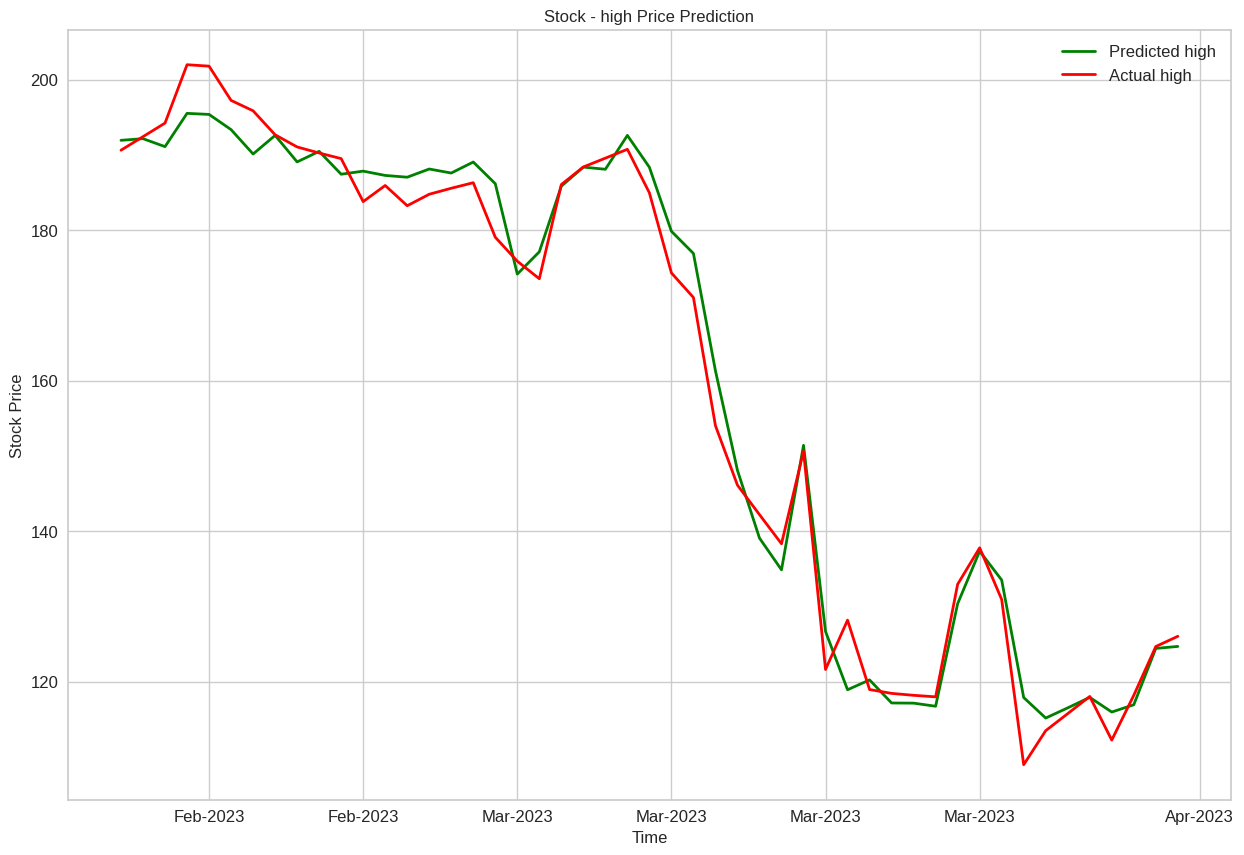

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======


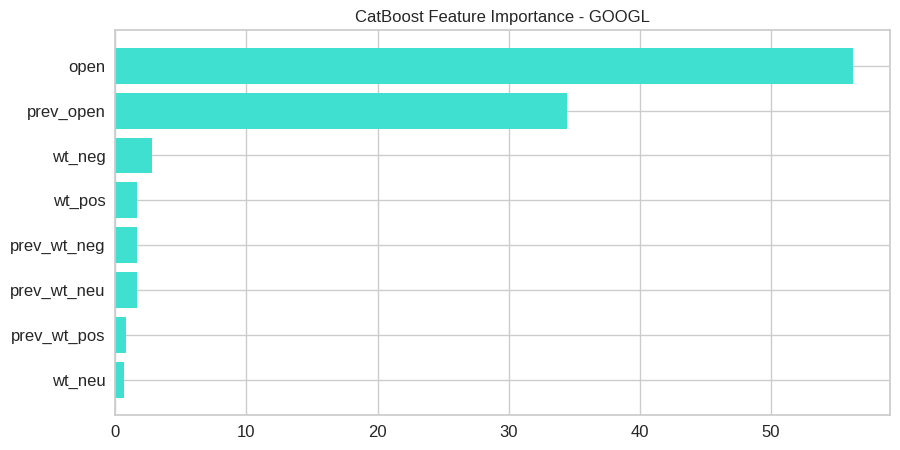

RMSE:			0.040983
MSE:			0.001680
MAE:			0.033576
R2 Score:		0.915593
Adj. R2 Score:		0.911923
Exp. Variance Score:	0.915615
Max Error:		0.126334
Predicted 	 Value
[0.29089858] 	 [0.26315796]
[0.27143143] 	 [0.25229747]
[0.2681524] 	 [0.24171538]
[0.24962288] 	 [0.23196882]
[0.25200042] 	 [0.29518254]
[0.28455354] 	 [0.310777]
[0.26561198] 	 [0.25174047]
[0.24758104] 	 [0.21748823]
[0.23521263] 	 [0.20022285]
[0.23241587] 	 [0.19159015]
[0.22063518] 	 [0.18323588]
[0.19102435] 	 [0.15566704]
[0.17853159] 	 [0.15093301]
[0.15495754] 	 [0.09384577]
[0.10510186] 	 [0.09774444]
[0.10694933] 	 [0.09969375]
[0.10495884] 	 [0.10136471]
[0.10705466] 	 [0.13116139]
[0.10512573] 	 [0.1255918]
[0.10559849] 	 [0.16040104]
[0.16044929] 	 [0.20077988]
[0.22531054] 	 [0.23196888]
[0.2359593] 	 [0.24756342]
[0.24526144] 	 [0.26315798]
[0.27287151] 	 [0.25480368]
[0.24841296] 	 [0.26287945]
[0.24069478] 	 [0.25090508]
[0.21093638] 	 [0.17460327]
[0.16506452] 	 [0.17154003]
[0.1319013] 	 [0.16986919]
[0.

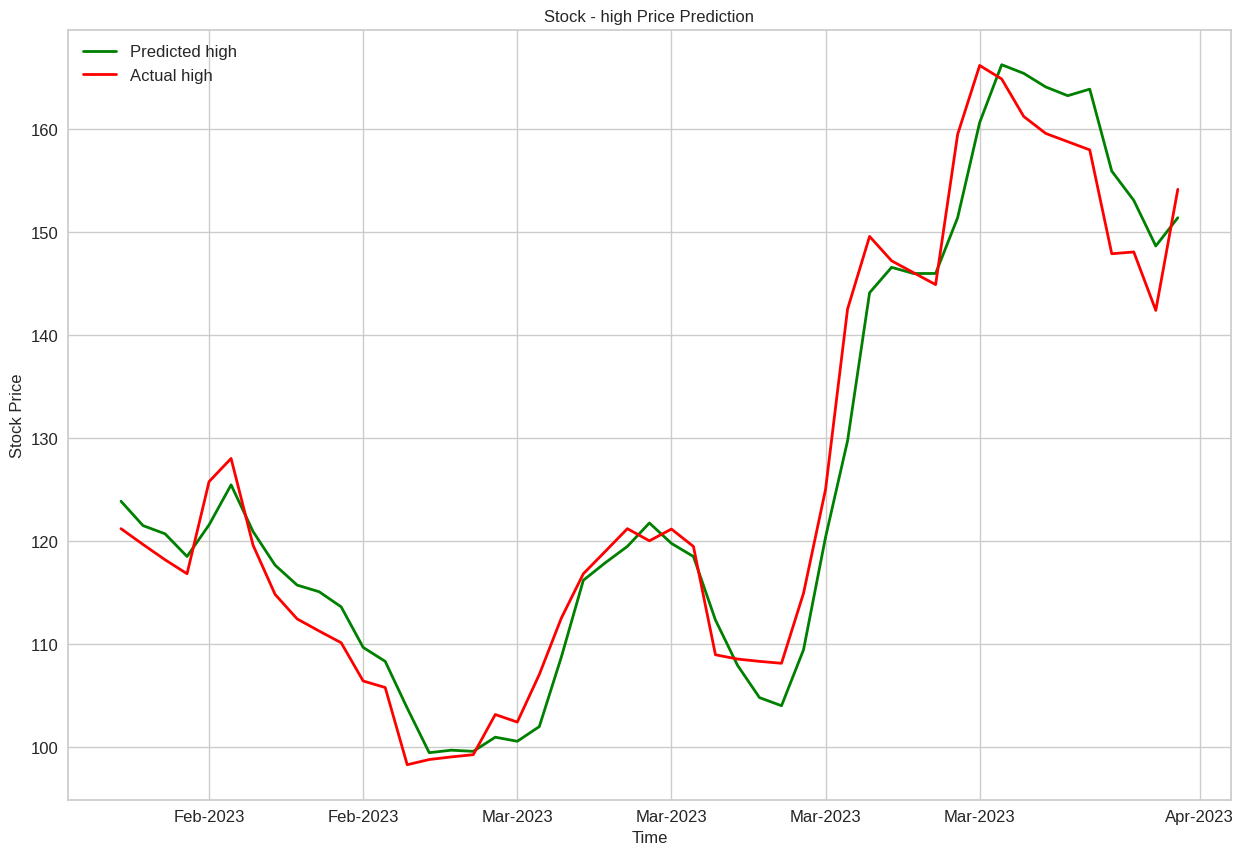

======FINISHED WORKING ON GOOGL======


In [43]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='high')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels,output_label='high')

# **Predicting Low Value**

In [44]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs, output_label='low')

both_open_dfs['TSLA']

,date,open,wt_neg,wt_neu,wt_pos,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,low
0,2022-08-02,294.003326,-22.682993,-25.073643,-37.357318,301.276672,-16.876412,-26.904634,-41.171774,292.666656
1,2022-08-03,305.000000,-2.331892,-6.009396,-13.196395,294.003326,-22.682993,-25.073643,-37.357318,301.149994
2,2022-08-04,311.000000,-1.167563,-2.196746,-3.635691,305.000000,-2.331892,-6.009396,-13.196395,305.000000
3,2022-08-05,302.670013,-16.216868,-16.855830,-160.879937,311.000000,-1.167563,-2.196746,-3.635691,285.543335
4,2022-08-06,298.840000,-5.747857,-10.603171,-13.781130,302.670013,-16.216868,-16.855830,-160.879937,287.320000
...,...,...,...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,-232.793960,-281.636459,-465.958222,193.720000,-14.594635,-21.290344,-30.107518,189.940002
238,2023-03-28,192.000000,-13.191043,-12.029059,-33.769606,194.419998,-232.793960,-281.636459,-465.958222,185.429993
239,2023-03-29,193.130005,-50.816797,-73.301693,-115.862161,192.000000,-13.191043,-12.029059,-33.769606,189.440002
240,2023-03-30,195.580002,-150.363192,-88.522910,-161.982104,193.130005,-50.816797,-73.301693,-115.862161,194.419998


In [45]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True,output_label='low')

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'low']
Data dimensions for TSLA: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'low']
Data dimensions for MS: (242, 9) 

['open', 'wt_neg', 'wt_neu', 'wt_pos', 'prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'low']
Data dimensions for GOOGL: (242, 9) 



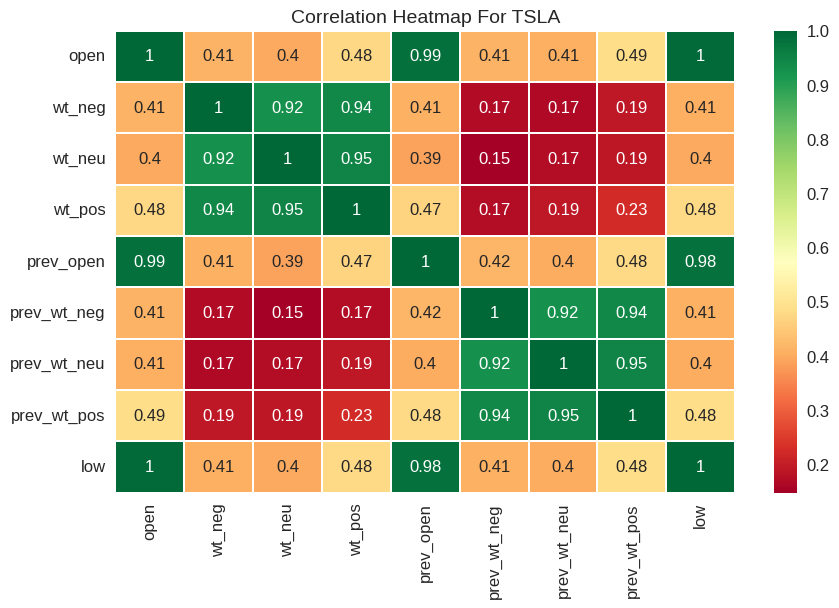

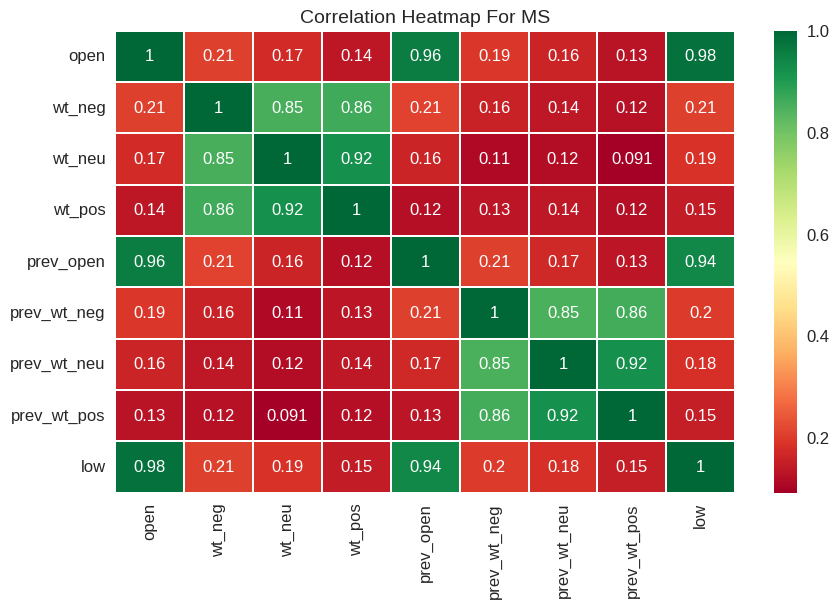

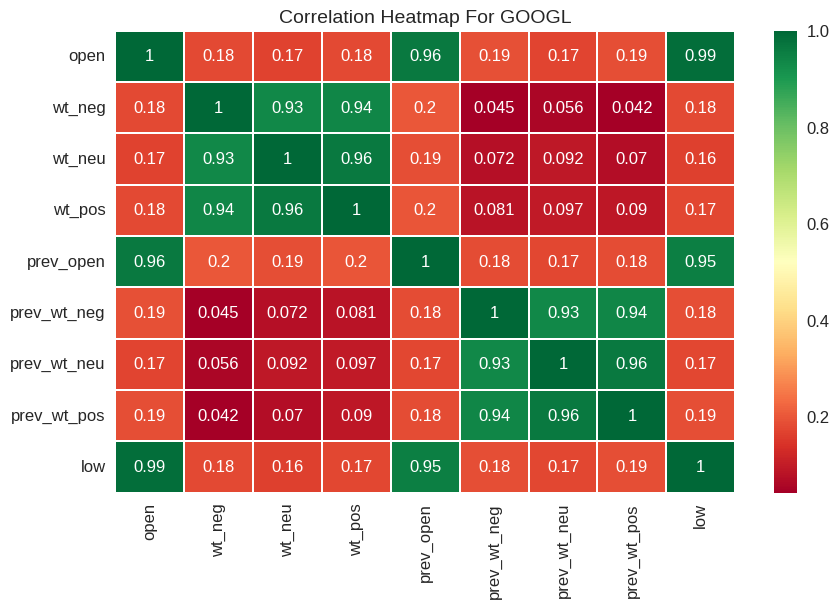

In [46]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======


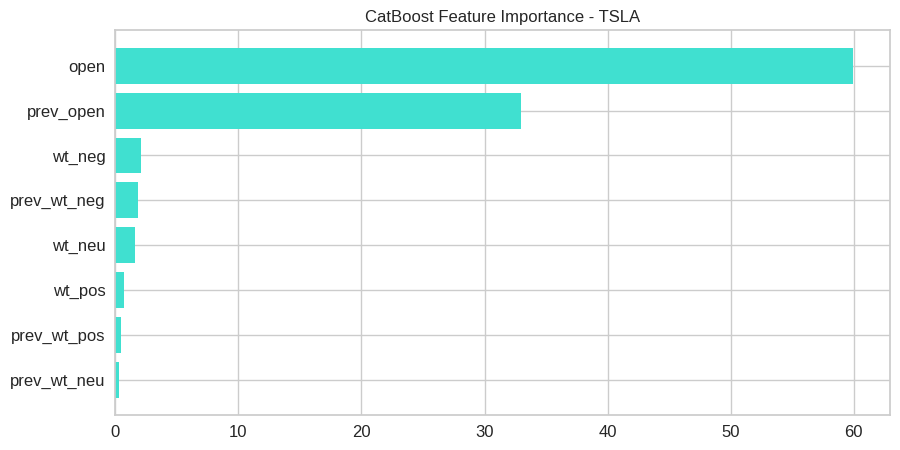

RMSE:			0.018238
MSE:			0.000333
MAE:			0.014119
R2 Score:		0.869059
Adj. R2 Score:		0.863366
Exp. Variance Score:	0.897058
Max Error:		0.052713
Predicted 	 Value
[0.44655503] 	 [0.43401878]
[0.43581584] 	 [0.42754089]
[0.45087229] 	 [0.421063]
[0.40987887] 	 [0.43004372]
[0.47688013] 	 [0.51185164]
[0.4921689] 	 [0.49089662]
[0.45912536] 	 [0.46959811]
[0.45471522] 	 [0.46891106]
[0.44985652] 	 [0.46856754]
[0.45983759] 	 [0.46842031]
[0.45260093] 	 [0.46822402]
[0.46637117] 	 [0.44152724]
[0.46137992] 	 [0.46385635]
[0.44487228] 	 [0.4465329]
[0.44608126] 	 [0.46729159]
[0.45573395] 	 [0.4776464]
[0.45998432] 	 [0.48805026]
[0.47041592] 	 [0.50026995]
[0.47725009] 	 [0.47460377]
[0.39446737] 	 [0.41321098]
[0.4236557] 	 [0.44692551]
[0.42519346] 	 [0.44550232]
[0.45004609] 	 [0.44481527]
[0.44605655] 	 [0.44407916]
[0.41478501] 	 [0.41365271]
[0.38116386] 	 [0.38371697]
[0.36418772] 	 [0.34695981]
[0.32745093] 	 [0.32698635]
[0.31285056] 	 [0.3158954]
[0.30370799] 	 [0.31034993]
[0.3

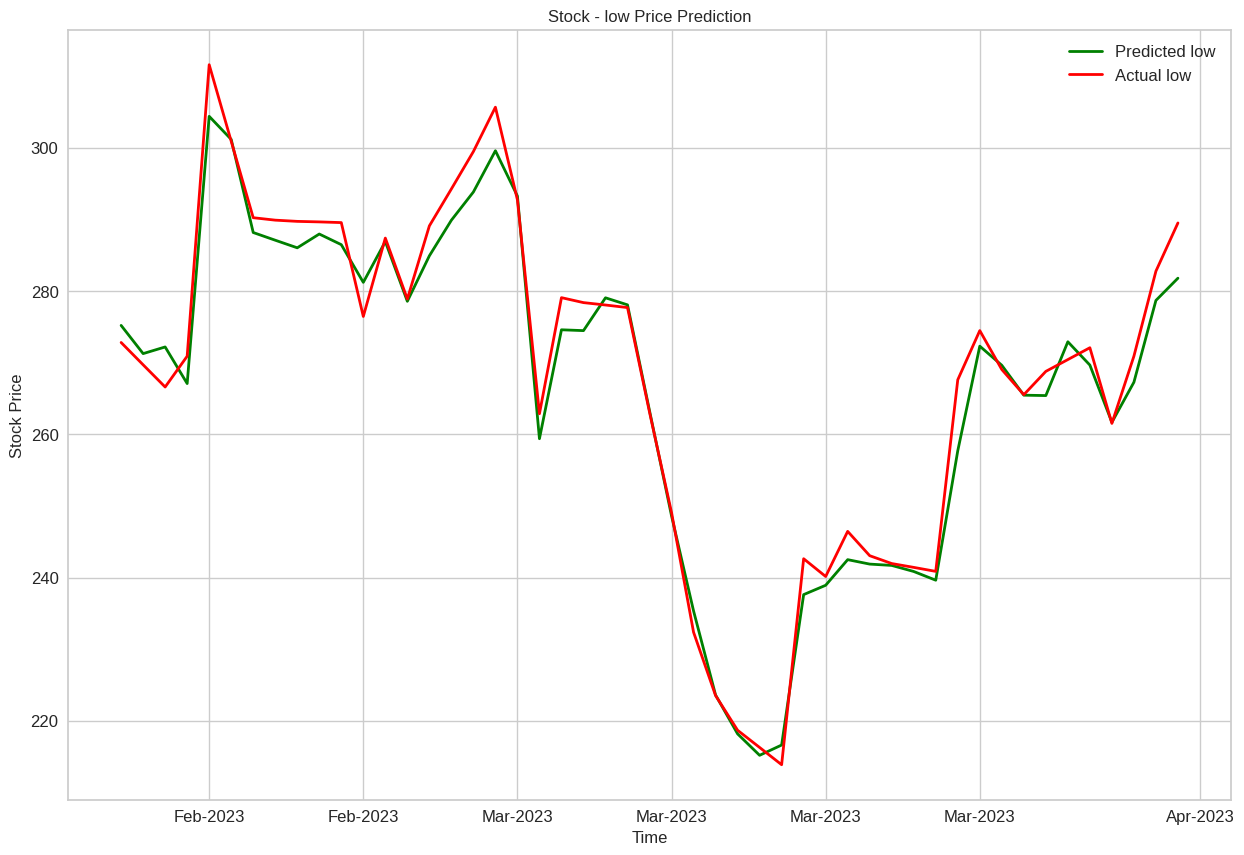

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======


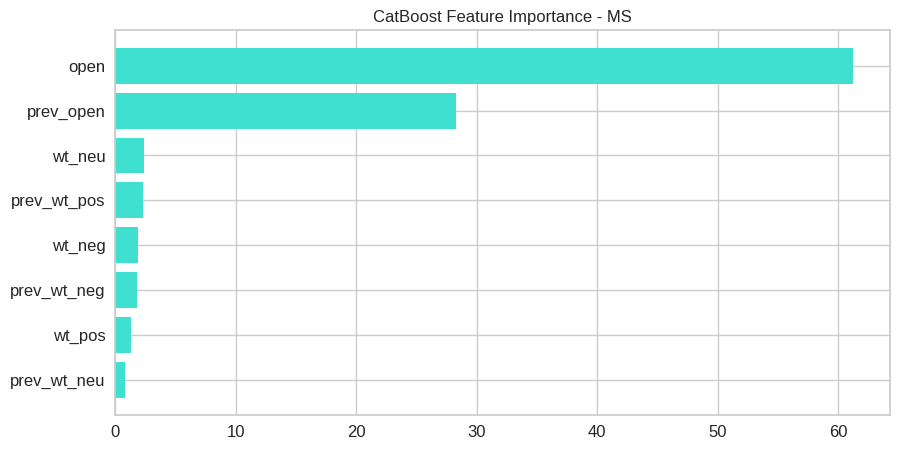

RMSE:			0.057160
MSE:			0.003267
MAE:			0.041711
R2 Score:		0.944626
Adj. R2 Score:		0.942219
Exp. Variance Score:	0.953376
Max Error:		0.164574
Predicted 	 Value
[0.92834658] 	 [0.93395087]
[0.92260436] 	 [0.93999195]
[0.90452879] 	 [0.94603319]
[0.92782547] 	 [0.97865489]
[0.91706882] 	 [1.]
[0.92834521] 	 [0.97221096]
[0.89686852] 	 [0.95167149]
[0.93108147] 	 [0.92911801]
[0.90795071] 	 [0.91784133]
[0.92549397] 	 [0.91220299]
[0.90267672] 	 [0.90656465]
[0.90451432] 	 [0.88401141]
[0.89486797] 	 [0.88723307]
[0.89688383] 	 [0.88360859]
[0.90106314] 	 [0.88320581]
[0.91336114] 	 [0.88280307]
[0.9142302] 	 [0.88240041]
[0.89470107] 	 [0.86951278]
[0.80867544] 	 [0.82923892]
[0.82245972] 	 [0.79782535]
[0.88312141] 	 [0.87716461]
[0.89754117] 	 [0.91018929]
[0.90372666] 	 [0.92670158]
[0.9350246] 	 [0.94361652]
[0.91689448] 	 [0.85783332]
[0.8633755] 	 [0.83326626]
[0.84167803] 	 [0.68868295]
[0.75096209] 	 [0.58638759]
[0.62944851] 	 [0.53443419]
[0.557665] 	 [0.50865892]
[0.5296645

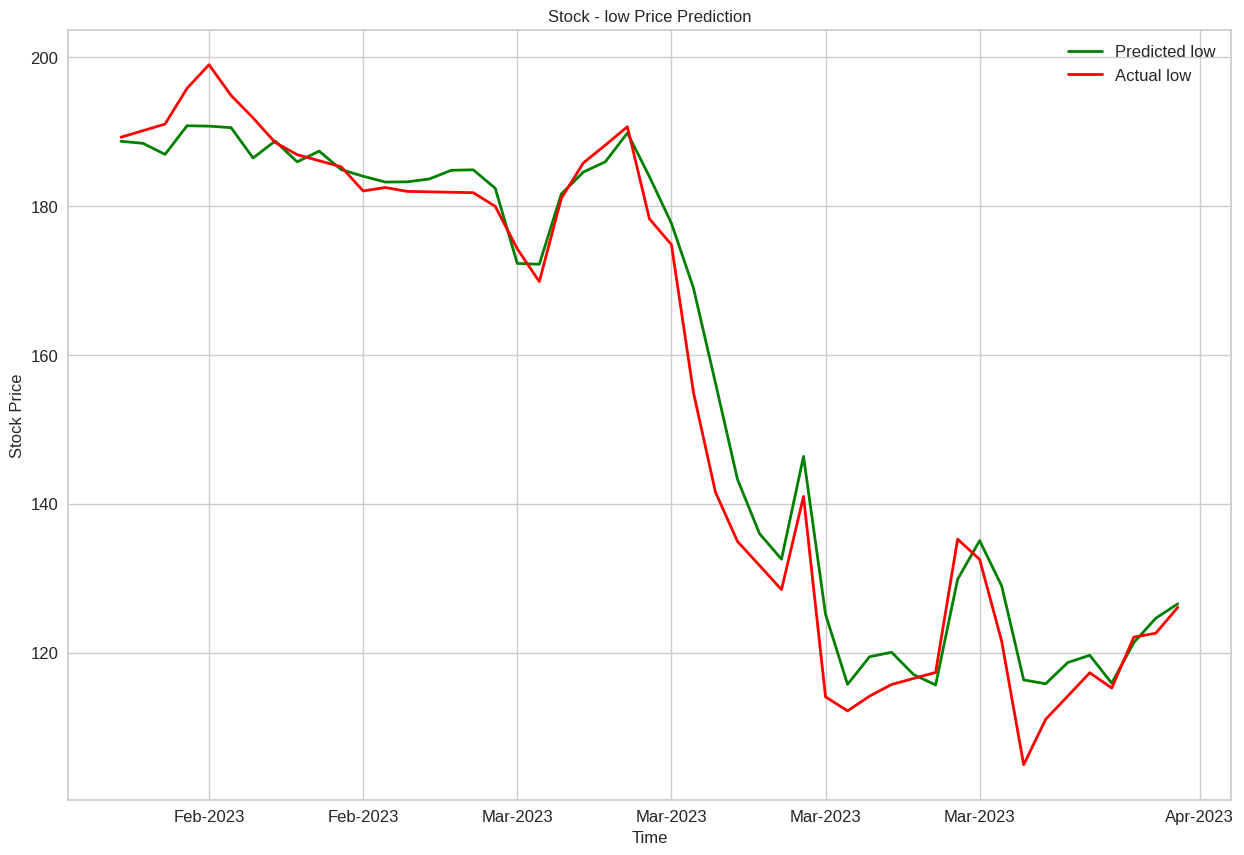

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======


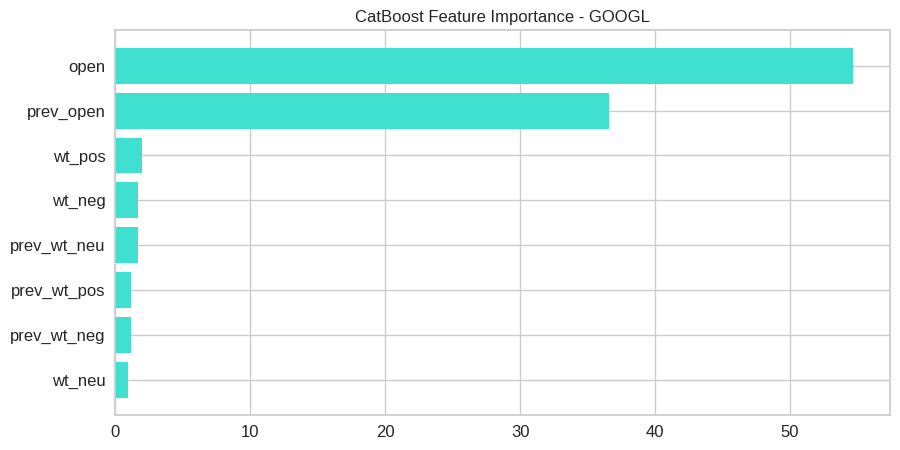

RMSE:			0.035381
MSE:			0.001252
MAE:			0.028556
R2 Score:		0.924187
Adj. R2 Score:		0.920890
Exp. Variance Score:	0.930231
Max Error:		0.089262
Predicted 	 Value
[0.29945821] 	 [0.28686335]
[0.27550021] 	 [0.28418239]
[0.27661285] 	 [0.28150132]
[0.25327142] 	 [0.23914223]
[0.24833269] 	 [0.28981247]
[0.28362207] 	 [0.30563006]
[0.27855077] 	 [0.26461132]
[0.25158193] 	 [0.24477221]
[0.23813522] 	 [0.23485264]
[0.2328729] 	 [0.2297588]
[0.22169413] 	 [0.224665]
[0.20475769] 	 [0.19490628]
[0.16023486] 	 [0.17211811]
[0.15415812] 	 [0.14048272]
[0.13048241] 	 [0.15067034]
[0.1292333] 	 [0.15576417]
[0.13066946] 	 [0.1608579]
[0.12771462] 	 [0.16032181]
[0.13647357] 	 [0.16970513]
[0.13380906] 	 [0.16756031]
[0.17139649] 	 [0.24423593]
[0.21722235] 	 [0.26487944]
[0.22786375] 	 [0.27533521]
[0.23992851] 	 [0.28579097]
[0.27953939] 	 [0.27319041]
[0.25188874] 	 [0.28579097]
[0.24505605] 	 [0.22949076]
[0.22364797] 	 [0.18927629]
[0.16799672] 	 [0.1761395]
[0.14467885] 	 [0.16943709]
[0.1

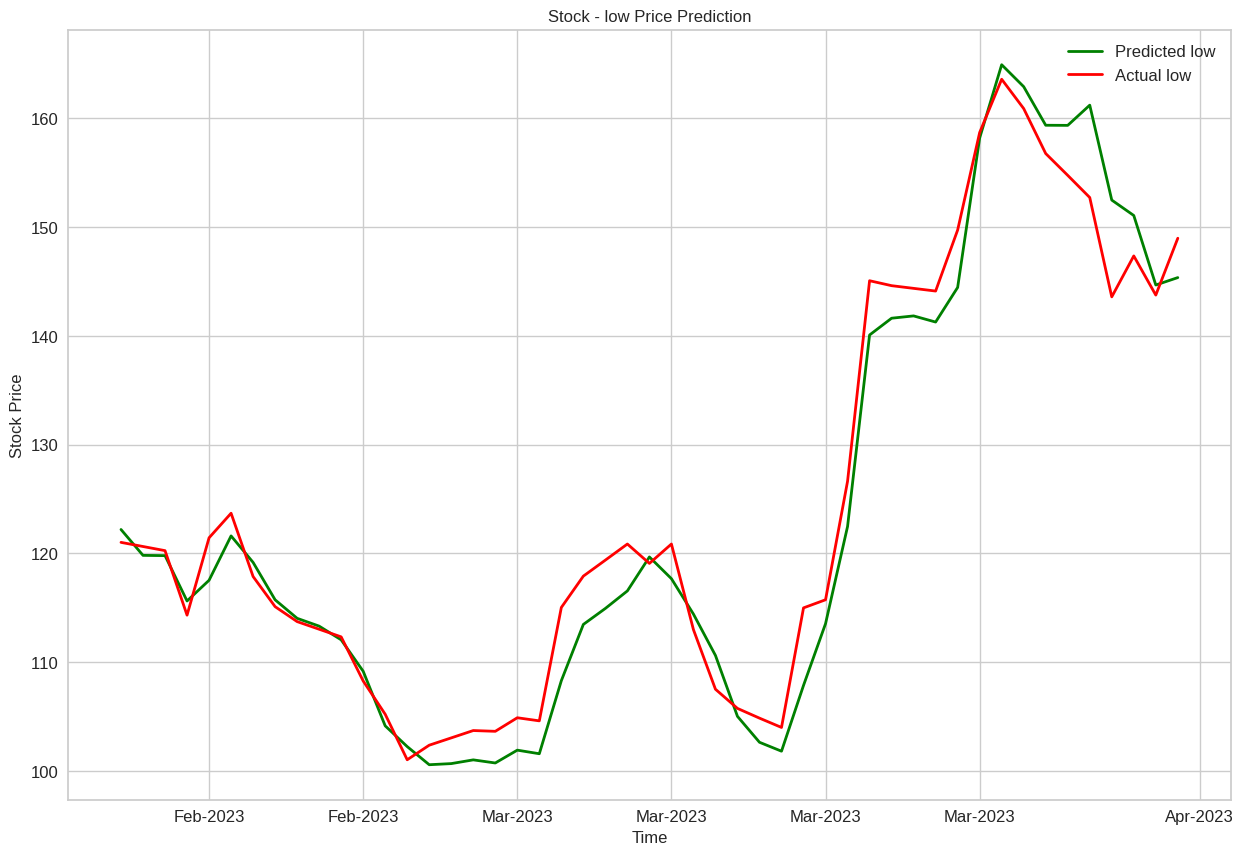

======FINISHED WORKING ON GOOGL======


In [47]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='low')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels,output_label='low')